<a href="https://colab.research.google.com/github/DannyTheFlower/PDA_Course/blob/main/practices/practice_5/PDA_P5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Постановка задачи и загрузка данных

В данной практической работе мы будем решать задачу сегментации изображений на примере датасета `PH2Dataset`. Данный датасет представляет собой медицинские снимки двух типов поражений кожи: родинки и меланомы. В рамках практической работы будем заниматься их сегментацией.

In [1]:
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json
!echo '{"username":"daniilpiatygo","key":"6a5c15c37176a5dd0af08791f3882e69"}' > /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d kanametov/ph2dataset

 96% 195M/203M [00:02<00:00, 72.5MB/s]
100% 203M/203M [00:02<00:00, 80.2MB/s]


In [3]:
!unzip -q ph2dataset.zip

Как можно видеть, датасет имеет следующую структуру:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Загрузим эти изображения в переменные.

In [4]:
from skimage.io import imread, imshow
import os

images = []
lesions = []
BASE_DIR = "/content/PH2Dataset/PH2_Dataset"

for root, dirs, files in os.walk(BASE_DIR):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Посмотрим на полученный результат.

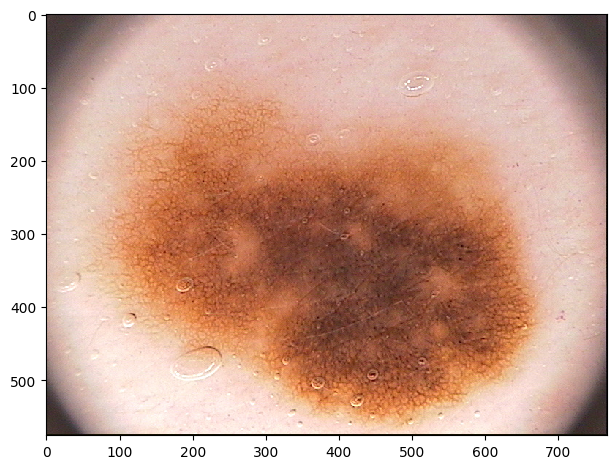

In [5]:
imshow(images[0])

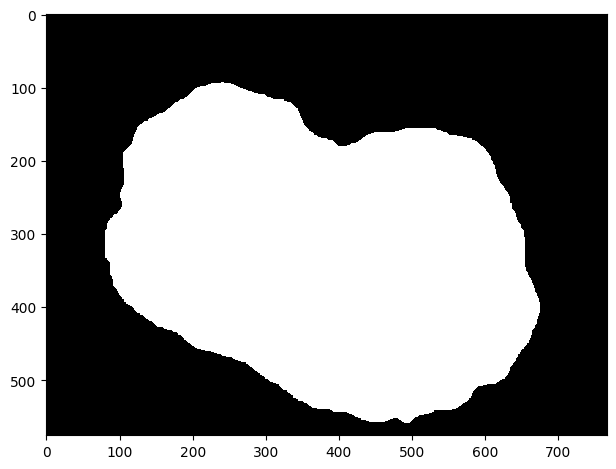

In [6]:
imshow(lesions[0])

# Предобработка

Для работы с изображениями необходимо привести их к одному размеру и нормализовать (например, с помощью `skimage.transform.resize()`).

In [7]:
from skimage.transform import resize

size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

Снова посмотрим на результат.

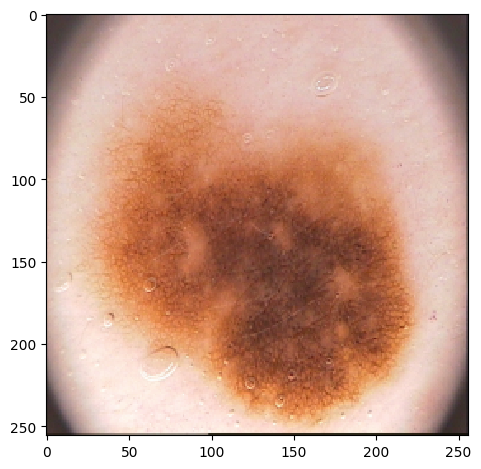

In [8]:
imshow(X[0])

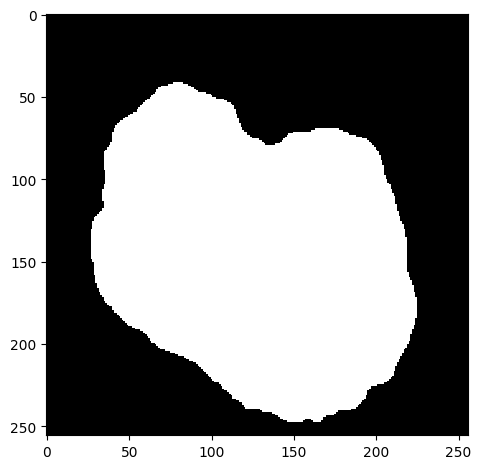

In [9]:
imshow(Y[0])

# Обучение

Разделим данные на тренировочные, тестовые и валидационные в отношении 100/50/50 и инициализируем DataLoader'ы.

In [10]:
%%capture
!pip install segmentation_models_pytorch torchmetrics

In [11]:
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch.nn as nn
import torch.optim as optim

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torchmetrics.classification import BinaryJaccardIndex

In [12]:
X = torch.tensor(X).float().permute(0, 3, 1, 2)
Y = torch.tensor(Y).float().unsqueeze(1)

dataset = TensorDataset(X, Y)
train_size = 100
test_size = 50
val_size = 50
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<ipython-input-12-fa36ec0cb528>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X = torch.tensor(X).float().permute(0, 3, 1, 2)
<ipython-input-12-fa36ec0cb528>:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  Y = torch.tensor(Y).float().unsqueeze(1)


Определим метрику качества. Для задачи сегментации удачным решением будет использовать IoU (Intersect over Union, известная также, как коэффициент Жаккара):

$\text{IoU}=\frac{\text{target } \cap \text{ prediction}}{\text {target } \cup \text{ prediction}}$

Иначе говоря, мы делим число совпавших пикселей в предсказанной и истинной маске на количество пикселей в объединении этих масок.

In [13]:
metric = BinaryJaccardIndex()

Обучим модель сегментации с помощью готовой архитектуры U-Net с функцией потерь DiceLoss и оптимизатором Adam.

In [14]:
encoder = "timm-efficientnet-b0"
weights = "imagenet"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 25
lr = 0.0003
metric.to(device)

BinaryJaccardIndex()

In [15]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.architecture = smp.Unet(
            encoder_name = encoder,
            encoder_weights=weights,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.architecture(images)

        if masks is not None:
            loss1 = DiceLoss(mode="binary")(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1+loss2

        return logits

In [16]:
model = SegmentationModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 95.2MB/s]


In [17]:
def train_model():
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            logits, loss = model(images, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                logits, loss = model(images, masks)
                val_loss += loss.item()

            val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

In [18]:
def eval_model():
    model.eval()

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5
            metric(preds.int(), masks.int())

    return metric.compute().item()

In [43]:
def predict(image):
    image_resized = resize(image, size, mode="constant", anti_aliasing=True)
    x = torch.tensor([image_resized]).float().permute(0, 3, 1, 2).to(device)

    model.eval()
    with torch.no_grad():
        output = model(x)
        preds = torch.sigmoid(output) > 0.5

    return preds.squeeze(0).permute(1, 2, 0).cpu()

In [19]:
train_model()

Epoch 1/25, Train Loss: 1.2671, Val Loss: 1.8833
Epoch 2/25, Train Loss: 1.1229, Val Loss: 1.2854
Epoch 3/25, Train Loss: 0.9650, Val Loss: 1.0542
Epoch 4/25, Train Loss: 0.8479, Val Loss: 0.9472
Epoch 5/25, Train Loss: 0.7764, Val Loss: 0.8135
Epoch 6/25, Train Loss: 0.6878, Val Loss: 0.7070
Epoch 7/25, Train Loss: 0.7076, Val Loss: 0.6108
Epoch 8/25, Train Loss: 0.6444, Val Loss: 0.5524
Epoch 9/25, Train Loss: 0.5437, Val Loss: 0.5164
Epoch 10/25, Train Loss: 0.5307, Val Loss: 0.5059
Epoch 11/25, Train Loss: 0.4883, Val Loss: 0.4830
Epoch 12/25, Train Loss: 0.4626, Val Loss: 0.4659
Epoch 13/25, Train Loss: 0.5512, Val Loss: 0.4509
Epoch 14/25, Train Loss: 0.4212, Val Loss: 0.4506
Epoch 15/25, Train Loss: 0.4313, Val Loss: 0.4398
Epoch 16/25, Train Loss: 0.4242, Val Loss: 0.4299
Epoch 17/25, Train Loss: 0.3855, Val Loss: 0.4241
Epoch 18/25, Train Loss: 0.3591, Val Loss: 0.4164
Epoch 19/25, Train Loss: 0.3450, Val Loss: 0.4066
Epoch 20/25, Train Loss: 0.3508, Val Loss: 0.3910
Epoch 21/

# Результаты

Оценим качество модели.

In [20]:
eval_model()

0.8857011198997498

Посмотрим на несколько экземпляров.

In [45]:
img = resize(images[0], size, mode="constant", anti_aliasing=True)
mask_true = resize(lesions[0], size, mode="constant", anti_aliasing=False)
mask_pred = predict(img)

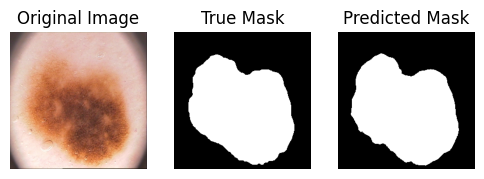

In [46]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(6, 6))

axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(mask_true, cmap="gray")
axes[1].set_title("True Mask")
axes[1].axis("off")

axes[2].imshow(mask_pred, cmap="gray")
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

plt.show()

На вид качество неплохое, однако метрику явно нужно улучшать, как минимум, до 0.9. Это можно сделать разными способами:

1. Подбор гиперпараметров (число эпох, learning rate)
2. Аугментация данных (повороты на разные углы, отзеркаливание)

Однако стоит отметить, что модель показала себя хорошо и имеет хороший потенциал для дальнейшего обучения.